In [25]:
import solver as sv
import numpy as np
import matplotlib.pyplot as plt

# Monitor internal power flow
Whithin the GenSol package it is also possible to monitor the power flowing inside the circuit, once the appropriate boundary conditions are supplied. To do this is necessary to define the structure for which to monitor the port before the simulation is done. This because no internal information can be extracted from the general scattering matrix of the system once it is build, and so the process of building the matrix has to be slightly modified in order to take this into account. 

For now this is more of a beta function. Possible changes in the syntax are still possible.

## Workflow

The adding of monitors is designed to be as painless as possible. The workflow is basically the same, with the addition of a few commands.

### Adding monitors
For adding monitors to the simulation two function are provided:
 - `Solver.monitor_structure(structure, name)`
 - `add_structure_to_monitors(structure, name)`

The two functions are exactly the same, with the only difference that the first one is a method of the `Solver` object, so it as to be called on one, while the other is implicitly acting on the active solver (for example, within a `with` statement).

Both functions accept as input a structure object (the one to be monitored) and a string (the name associated with the monitor). In this way, after running the simulation, is possible to retrieve information about the modal coefficients at the input and output ports of the monitored structure

As for now monitors are only available at top level. If a monitor is defined for a solver which is then nested into another, access to the monitor is lost (but the full simulation of the top solver will work just fine)

### Accessing the data
Once the simulation is complete (by calling the `solve` method) and the `SolvedModel` is obtained, getting the data from the monitor is just a matter of calling the method `get_monitor(input_dic)` on the obtained `SolvedModel`. The method takes a input a dictionary if the inputs coefficients (see also the method `get_full_output`) and returns a pandas `DataFrame` object wiht the results. The `DataFrame` contains a columns for each parameter provided to `solve`, plus two columns for each pin of each structure to be monitored (one columns contain the input coefficient, the other the output coefficients). 
Additionaly, the method also a boolean keyword argument `power`. If `True` (default) the returned vector contain the power in the modes (modulus squared of th coefficients), otherwise the full vector of complex coefficient is returned. 



## Examples

### Add-Drop filter
Typical case of use of such feature is the monitoring of the stored power inside a resonator. So, we will built a standard add-drop filter and use this method to calculate the field enhanced inside the ring.

In [26]:
with sv.Solver() as AddDrop:
    BM = sv.BeamSplitter(ratio=0.1)
    WG = sv.Waveguide(100.0)
    bm1 = BM.put()
    bm2 = BM.put()
    wg1 = WG.put()
    wg2 = WG.put()
    sv.connect(bm1.pin['b1'], wg1.pin['a0'])
    sv.connect(bm2.pin['b0'], wg1.pin['b0'])
    sv.connect(bm1.pin['a1'], wg2.pin['a0'])
    sv.connect(bm2.pin['a0'], wg2.pin['b0'])
    sv.raise_pins()
    sv.add_structure_to_monitors(wg1, 'right')
    




Once the circuit is defined, we could plot the transmission spectrum to check it is working. 

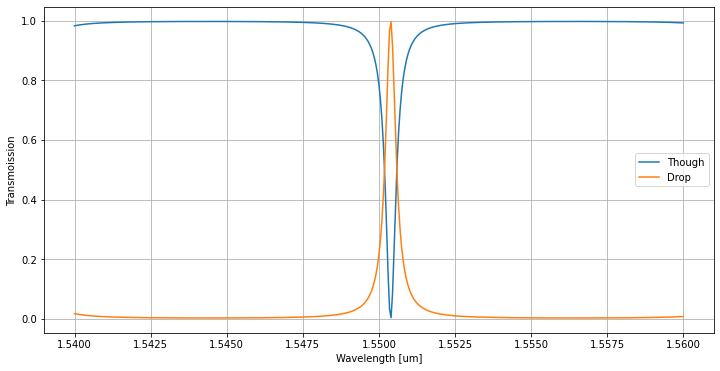

In [27]:
wll = np.linspace(1.54,1.56,401)
M = AddDrop.solve(wl=wll)
T = M.get_data('a0','b0')
D = M.get_data('a0','a1')
plt.figure(figsize=(12,6))
plt.plot(wll, T['T'], label = 'Though')
plt.plot(wll, D['T'], label = 'Drop')
plt.xlabel('Wavelength [um]')
plt.ylabel('Transmoission')
plt.grid()
plt.legend()

At this point we could check the internal power by doing:

In [28]:
I = M.get_monitor({'a0' : 1.0})
print(I)

          wl  right_b0_i  right_b0_o  right_a0_i  right_a0_o
0    1.54000         0.0    0.173387    0.173387         0.0
1    1.54005         0.0    0.163423    0.163423         0.0
2    1.54010         0.0    0.154342    0.154342         0.0
3    1.54015         0.0    0.146044    0.146044         0.0
4    1.54020         0.0    0.138441    0.138441         0.0
..       ...         ...         ...         ...         ...
396  1.55980         0.0    0.067108    0.067108         0.0
397  1.55985         0.0    0.069228    0.069228         0.0
398  1.55990         0.0    0.071474    0.071474         0.0
399  1.55995         0.0    0.073855    0.073855         0.0
400  1.56000         0.0    0.076382    0.076382         0.0

[401 rows x 5 columns]


As can be seen, the table obtained has 4 coulums of infomation, named form the name of the monittor, the name of the pin and 'i/o' indicating the direction of the mode. In this case light is traveling only in one direction ('a0'->'b0'), so two of the columns ('b0_i' and 'a0_o') are zeros. Moreover, since the waveguide is lossless, the input and output power coincide, the the two remaining columns are equal. To get the feeling of the magnitude of the files inside, we could plot the result:

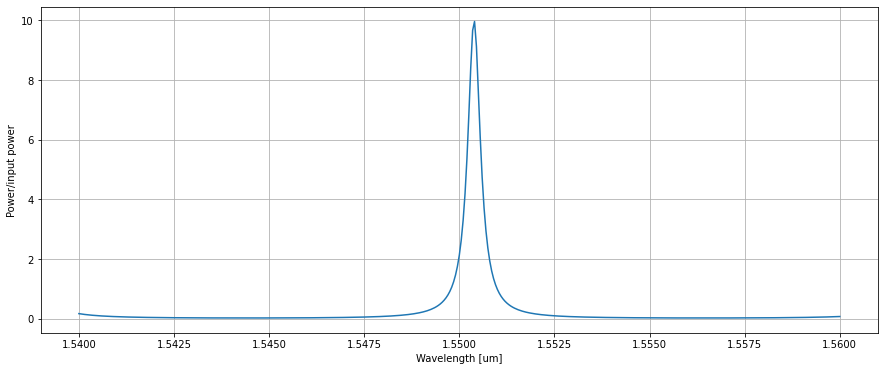

In [29]:
plt.figure(figsize=(15,6))
plt.plot(wll, I['right_a0_i'])
plt.xlabel('Wavelength [um]')
plt.ylabel('Power/input power')
plt.grid()


### Adding more monitors
It is indeed possible to monitor more than one structure, simply by adding more of them. To illustrate also the use of `Solver.monitor_structure(structure, name)`, we will add another monitor to the add-drop already available.

In [30]:
AddDrop.monitor_structure(wg2, 'left')
M = AddDrop.solve(wl=wll)
I = M.get_monitor({'a0' : 1.0})
I

,wl,right_a0_i,right_a0_o,left_a0_i,left_a0_o,right_b0_i,right_b0_o,left_b0_i,left_b0_o
0,1.54000,0.173387,0.0,0.0,0.156048,0.0,0.173387,0.156048,0.0
1,1.54005,0.163423,0.0,0.0,0.147081,0.0,0.163423,0.147081,0.0
2,1.54010,0.154342,0.0,0.0,0.138908,0.0,0.154342,0.138908,0.0
3,1.54015,0.146044,0.0,0.0,0.131439,0.0,0.146044,0.131439,0.0
4,1.54020,0.138441,0.0,0.0,0.124597,0.0,0.138441,0.124597,0.0
...,...,...,...,...,...,...,...,...,...
396,1.55980,0.067108,0.0,0.0,0.060397,0.0,0.067108,0.060397,0.0
397,1.55985,0.069228,0.0,0.0,0.062305,0.0,0.069228,0.062305,0.0
398,1.55990,0.071474,0.0,0.0,0.064326,0.0,0.071474,0.064326,0.0
399,1.55995,0.073855,0.0,0.0,0.066469,0.0,0.073855,0.066469,0.0


As we see now, the `DataFrame` has 8 columns of information. The same consideration on direction and intensity of light as before apply. The results are plotted for completeness. As we will see, the power in the two monitor will not be the same, since part of it is dropped half-way of the ring. 

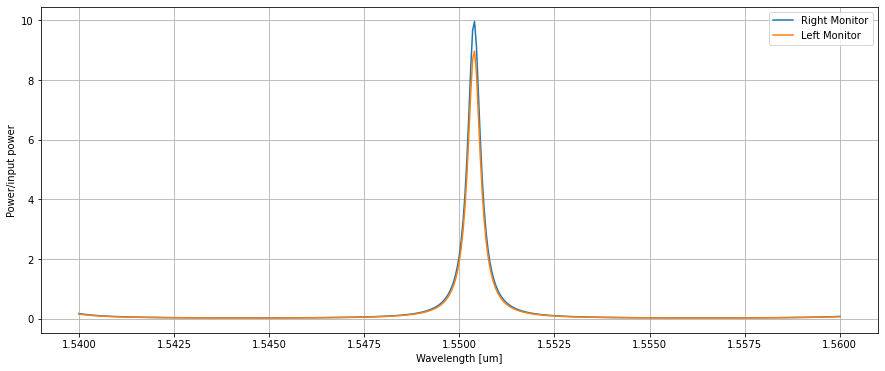

In [31]:
plt.figure(figsize=(15,6))
plt.plot(wll, I['right_a0_i'], label='Right Monitor')
plt.plot(wll, I['left_b0_i'], label='Left Monitor')
plt.legend()
plt.xlabel('Wavelength [um]')
plt.ylabel('Power/input power')
plt.grid()